In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.decomposition import LatentDirichletAllocation
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-08-23 12:18:14.226287: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
df = pd.read_csv('Stress.csv')

In [65]:
df.describe()

,label,confidence,social_timestamp,word_count
count,2838.000000,2838.000000,2.838000e+03,2838.000000
mean,0.524313,0.808972,1.518107e+09,85.669838
std,0.499497,0.177038,1.552209e+07,32.292305
min,0.000000,0.428571,1.483274e+09,1.000000
25%,0.000000,0.600000,1.509698e+09,65.000000
50%,1.000000,0.800000,1.517066e+09,80.000000
75%,1.000000,1.000000,1.530898e+09,101.000000
max,1.000000,1.000000,1.542592e+09,310.000000


In [59]:
missing_values = df.isnull().sum()
print(missing_values)


subreddit           0
post_id             0
sentence_range      0
text                0
label               0
confidence          0
social_timestamp    0
contextual_text     0
dtype: int64


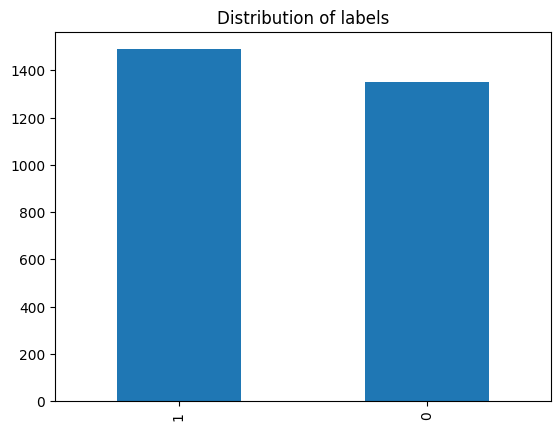

In [61]:
import matplotlib.pyplot as plt

df['label'].value_counts().plot(kind='bar')
plt.title('Distribution of labels')
plt.show()


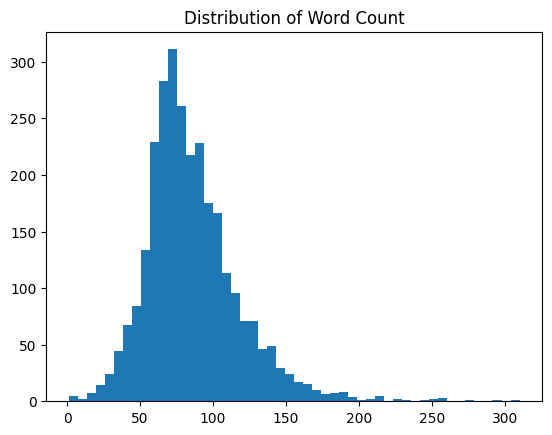

In [62]:
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
plt.hist(df['word_count'], bins=50)
plt.title('Distribution of Word Count')
plt.show()


#### Feature Engineering

In [26]:
# a. Individual Sentences:
texts = df['text']


In [27]:
# b. Contextual Data:
def combine_context(row):
    start_range = int(row['sentence_range'].strip('[]()').split(',')[0])
    return ' '.join(df.loc[max(row.name-start_range, 0):row.name]['text'])

df['contextual_text'] = df.apply(combine_context, axis=1)


In [28]:
# 2. Feature Extraction and Model Training:

# a. Individual Sentences:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(texts)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [37]:
# Model:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
clf = LogisticRegression(class_weight=class_weight_dict)


clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# b. Contextual Data:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['contextual_text'])

X_context = tokenizer.texts_to_sequences(df['contextual_text'])
X_context = pad_sequences(X_context, maxlen=100)

X_context_train, X_context_test, y_context_train, y_context_test = train_test_split(X_context, y, test_size=0.2, random_state=42)


In [42]:
# Model:
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128))
model.add(GRU(128))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_context_train, y_context_train, class_weight=class_weight_dict,epochs=5, batch_size=64, validation_split=0.1)


Epoch 1/5
32/32 [==============================] - 15s 273ms/step - loss: 0.6888 - accuracy: 0.5277 - val_loss: 0.6874 - val_accuracy: 0.5507
Epoch 2/5
32/32 [==============================] - 11s 355ms/step - loss: 0.5545 - accuracy: 0.7352 - val_loss: 0.6541 - val_accuracy: 0.6388
Epoch 3/5
32/32 [==============================] - 10s 319ms/step - loss: 0.3222 - accuracy: 0.8610 - val_loss: 0.7060 - val_accuracy: 0.6696
Epoch 4/5
32/32 [==============================] - 11s 334ms/step - loss: 0.1626 - accuracy: 0.9422 - val_loss: 0.8925 - val_accuracy: 0.6784
Epoch 5/5
32/32 [==============================] - 11s 330ms/step - loss: 0.1162 - accuracy: 0.9623 - val_loss: 1.0473 - val_accuracy: 0.6872


In [43]:
# 3. Thematic Extraction:
logistic_predictions = clf.predict(X)
gru_predictions = (model.predict(X_context) > 0.5).astype(int).flatten()  # Assuming a threshold of 0.5 for binary classification

overlap = np.where((logistic_predictions == 1) & (gru_predictions == 1))[0]
stress_texts = df.iloc[overlap]['text']# This should give the number of overlapping instances

# LDA:
vectorizer_lda = TfidfVectorizer(max_features=1000)
X_lda = vectorizer_lda.fit_transform(stress_texts)
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X_lda)


89/89 [==============================] - 4s 32ms/step


LatentDirichletAllocation(n_components=5, random_state=42)

In [44]:
# 4. Evaluation and Analysis:
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Logistic Regression F1 Score: {f1_score(y_test, y_pred)}")
print(f"Logistic Regression AUC-ROC: {roc_auc_score(y_test, y_pred)}")

loss, accuracy = model.evaluate(X_context_test, y_context_test)
print(f"GRU Accuracy: {accuracy}")



Logistic Regression Accuracy: 0.7411971830985915
Logistic Regression F1 Score: 0.7529411764705882
Logistic Regression AUC-ROC: 0.7417378295829957
18/18 [==============================] - 1s 32ms/step - loss: 0.9951 - accuracy: 0.6884
GRU Accuracy: 0.6883803009986877


In [46]:
# Visualize LDA topics:
for idx, topic in enumerate(lda.components_):
    print(f"Top words for topic #{idx}:")
    print([vectorizer_lda.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
    print("\n")


Top words for topic #0:
['wall', 'appreciated', 'stomach', 'example', 'dying', 'fun', 'miserable', 'waiting', 'tips', 'pick']


Top words for topic #1:
['throughout', 'actual', 'offer', 'manage', 'pick', 'appreciated', 'cold', 'falling', 'dying', 'tips']


Top words for topic #2:
['using', 'doctors', 'charges', 'period', 'card', 'interest', 'heart', 'dont', 'rate', 'suicidal']


Top words for topic #3:
['dark', 'breathe', 'overcome', 'rate', 'cold', 'tips', 'suicidal', 'pick', 'falling', 'dying']


Top words for topic #4:
['was', 'that', 'of', 'he', 'me', 'it', 'the', 'my', 'and', 'to']




Topic #0:
Theme: Emotional distress and seeking advice

Keywords: wall, appreciated, stomach, example, dying, fun, miserable, waiting, tips, pick

Interpretation: This topic might represent posts where individuals are expressing feelings of being "up against a wall" or feeling "miserable". They could be looking for "tips" and advice, which is indicated by words like "appreciated".




Topic #1:
Theme: Coping and seeking guidance

Keywords: throughout, actual, offer, manage, pick, appreciated, cold, falling, dying, tips

Interpretation: This topic might represent posts about trying to "manage" certain feelings or situations. The presence of words like "offer" and "appreciated" suggest seeking or offering help. The words "falling" and "dying" indicate emotional distress.




Topic #2:
Theme: Medical and financial concerns

Keywords: using, doctors, charges, period, card, interest, heart, dont, rate, suicidal

Interpretation: This topic seems to blend medical concerns (e.g., "doctors", "heart") with financial worries (e.g., "charges", "card", "interest rate"). The word "suicidal" is alarming and indicates severe emotional distress.



Topic #3:
Theme: Emotional despair and seeking help

Keywords: dark, breathe, overcome, rate, cold, tips, suicidal, pick, falling, dying

Interpretation: The presence of words like "dark", "breathe", and "overcome" suggests deep emotional turmoil and attempts to cope. The repeated mention of words like "suicidal", "falling", and "dying" across topics underscores the gravity of the sentiments being expressed.



Topic #4:
Theme: Personal narratives

Keywords: was, that, of, he, me, it, the, my, and, to

Interpretation: These are mostly common English stop words, suggesting this topic captures more general narratives or common language structures. In LDA, sometimes one topic can capture the background noise of the dataset.



From these topics, it's clear that the dataset has a strong emotional component, with many individuals expressing distress, seeking advice, or discussing personal challenges.

#### HYPERPARAMETER TUNING

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for logistic regression
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], # Regularization parameter
    'penalty': ['l1', 'l2'], # Specifies the norm used in the penalization
    'solver': ['liblinear', 'saga']
}

# Define the model using the provided setup
clf = LogisticRegression(class_weight=class_weight_dict)

# Setup grid search
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get best parameters and best score
print(grid_search.best_params_)
print(grid_search.best_score_)


/Users/mac/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A Nu

{'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
0.7581497797356829


/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy: 0.7183
F1 Score: 0.7377
Precision: 0.7377
Recall: 0.7377
ROC-AUC: 0.8016


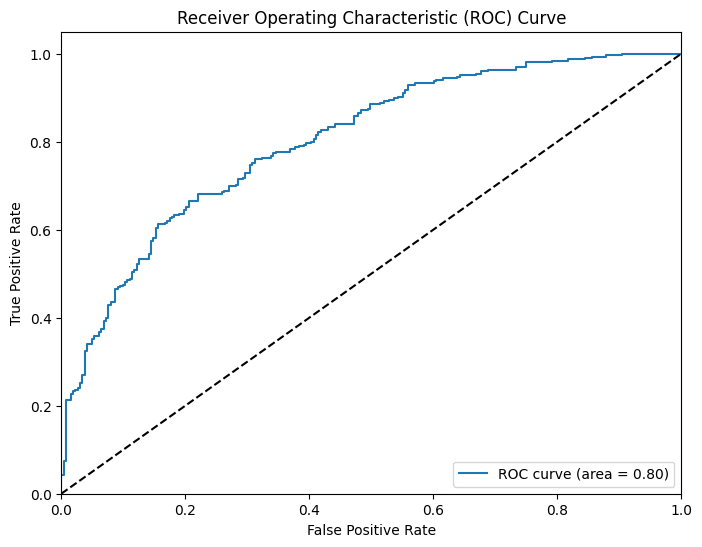

In [58]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Use the best estimator to make predictions on the test set
y_pred = grid_search.best_estimator_.predict(X_test)
y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]  # Probability estimates of the positive class

# 2. Compute various metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()




